Keras의 신경망을 사용해 핵 분할하는 방법을 보여줌.

U-NET을 사용하며 이미지 분할 문제에 자주 사용된다.

In [38]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Get the data
먼저 이미지와 관련 마스크를 가져옴. 

작업을 가볍고 관리하기 쉽게 유지하기 위해 훈련 이미지와 테스트 이미지를 모두 다운샘플링 하지만, 

예측된 마스크를 업샘플링하고 나중에 올바른 실행 길이 인코딩을 생성하려면 테스트 이미지의 원래 크기를 기록해야함.

In [17]:
# 훈련 이미지와 마스크 RESIZE
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
print("Getting and resizing train images and masks ...")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant',
                                      preserve_range=True), axis = -1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# 테스트 이미지 RESIZE
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
print("Getting and resizing test images ...")
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ...


100%|██████████| 670/670 [04:55<00:00,  2.27it/s]

Getting and resizing test images ...



100%|██████████| 65/65 [00:02<00:00, 29.86it/s]

Done!


임의의 이미지와 관련 마스크를 그려서 상황이 괜찮은지 살펴보겠음.

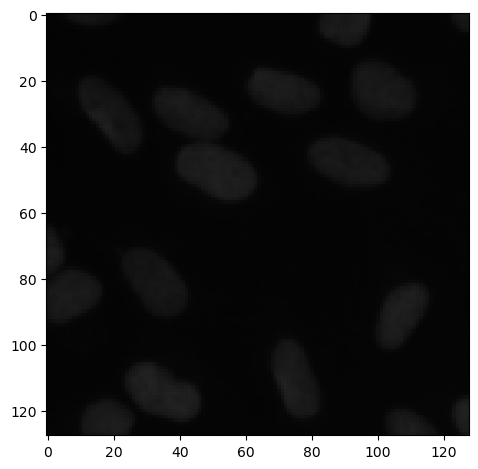

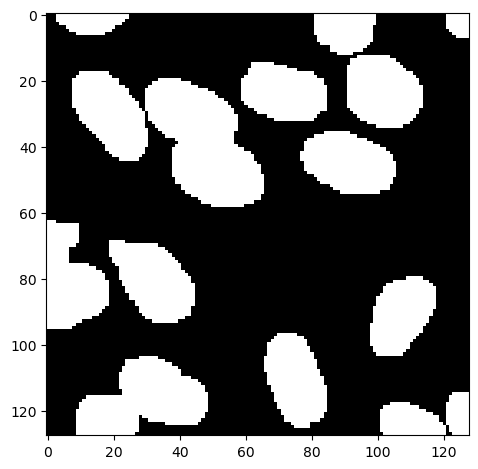

In [22]:

ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Keras metric 만들기
이제 우리는 Keras의 다양한 IoU(Intersection Over Union) 임계값 메트릭에서 평균 평균 정밀도를 정의하려고 한다.

Intersection over Union (IoU)"는 이미지 분할 및 객체 검출 작업에서 주로 사용되는 메트릭 중 하나로, 예측된 객체와 실제 객체 간의 겹치는 부분을 측정하는 데 사용됩니다. 높은 IoU 값은 정확한 객체 위치 예측을 나타냅니다.

"Mean Average Precision (mAP)"은 객체 검출 작업에서 사용되는 메트릭 중 하나로, 다양한 IoU 임계값에 대한 평균 IoU 값을 계산하는 메트릭입니다. 여러 임계값에서의 정밀도를 평균화하여 객체 검출 성능을 평가합니다.

In [47]:
# IoU metric 정의
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.cast((y_pred > t), tf.int32)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().rum(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis = 0)

from tensorflow.keras.metrics import MeanIoU

# ...

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast((y_pred > t), tf.int32)
        iou = MeanIoU(num_classes=2)
        iou.update_state(y_true, y_pred_)
        score = iou.result().numpy()
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Neural Network 구축 및 훈련
U-Net 모델

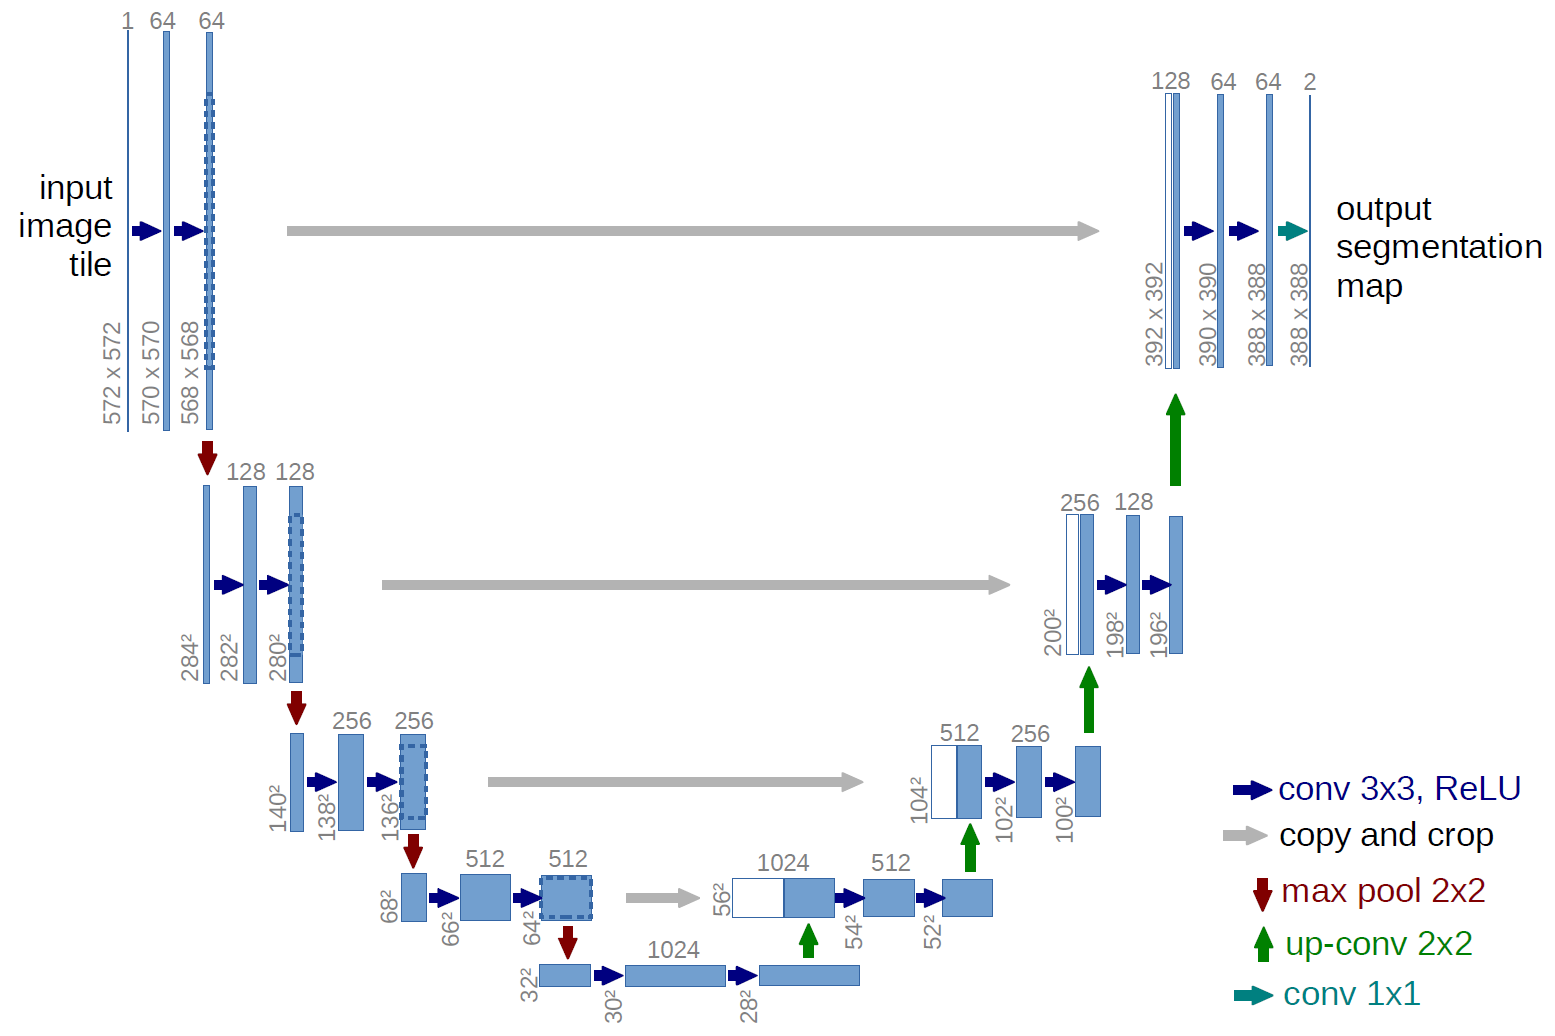

In [48]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 128, 128, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_57 (Conv2D)          (None, 128, 128, 16)         448       ['lambda_3[0][0]']            
                                                                                                  
 dropout_27 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_57[0][0]']           
                                                                                            

In [49]:
# 모델 정의 및 컴파일

# eager execution 모드 활성화
tf.config.run_functions_eagerly(True)

# 모델 훈련

# eager execution 모드 비활성화 (선택적)
# tf.config.run_functions_eagerly(False)


In [50]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/50


38/38 [==============================] - ETA: 0s - loss: 0.4352 - mean_iou: 0.4965
Epoch 1: val_loss improved from inf to 0.22651, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 57s 1s/step - loss: 0.4352 - mean_iou: 0.4965 - val_loss: 0.2265 - val_mean_iou: 0.6768
Epoch 2/50


c:\Users\com\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - ETA: 0s - loss: 0.2279 - mean_iou: 0.7055
Epoch 2: val_loss did not improve from 0.22651
38/38 [==============================] - 56s 1s/step - loss: 0.2279 - mean_iou: 0.7055 - val_loss: 0.3180 - val_mean_iou: 0.7075
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.1778 - mean_iou: 0.7672
Epoch 3: val_loss improved from 0.22651 to 0.14664, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 56s 1s/step - loss: 0.1778 - mean_iou: 0.7672 - val_loss: 0.1466 - val_mean_iou: 0.7977
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.1626 - mean_iou: 0.8004
Epoch 4: val_loss improved from 0.14664 to 0.13585, saving model to model-dsbowl2018-1.h5
38/38 [==============================] - 56s 1s/step - loss: 0.1626 - mean_iou: 0.8004 - val_loss: 0.1359 - val_mean_iou: 0.8405
Epoch 5/50
38/38 [==============================] - ETA: 0s - loss: 0.1418 - mean_iou: 0.8230
Epoch 5: val_loss imp

## Make predictions
테스트 세트, val 세트, Train 세트 모두에 대해 예측.

조기 중지 및 체크포인트를 사용한 경우 가장 잘 저장된 모델을 로드하는 것을 잊지 마라.

In [51]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode = 'constant', preserve_range=True))

3/3 [==============================] - 1s 214ms/step


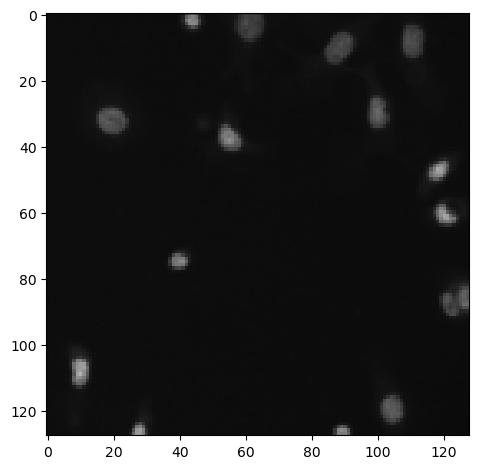

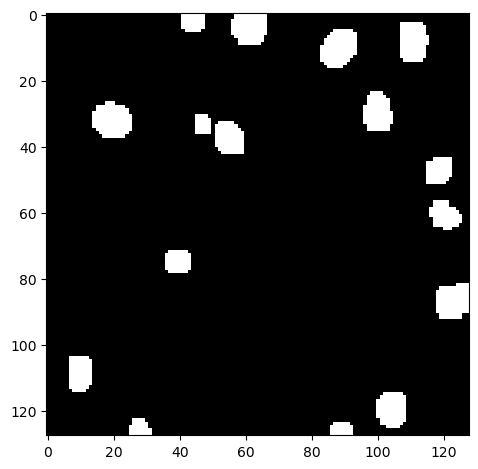

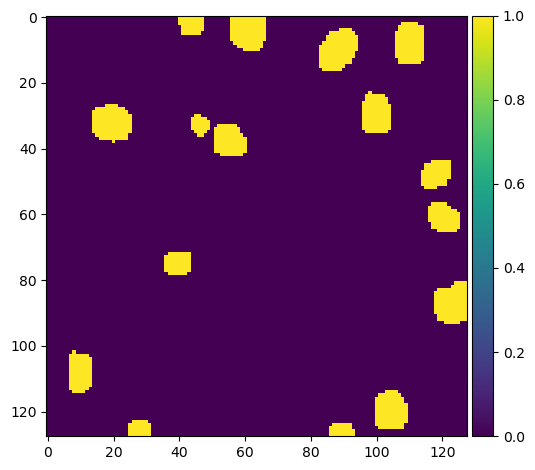

In [52]:
# 일부 무작위 훈련 샘플에 대해 온전성 검사
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

모델은 최소한 훈련 데이터에 적합할 수 있음. 검증 데이터는 어떨까

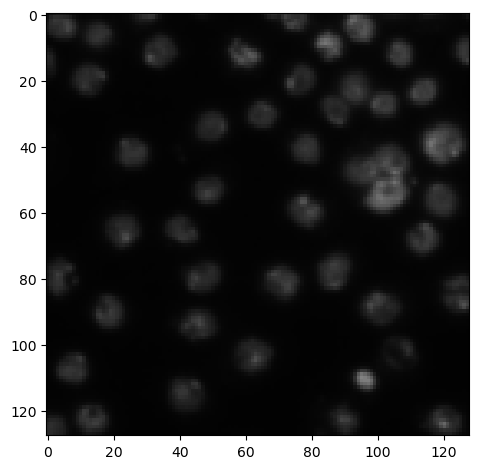

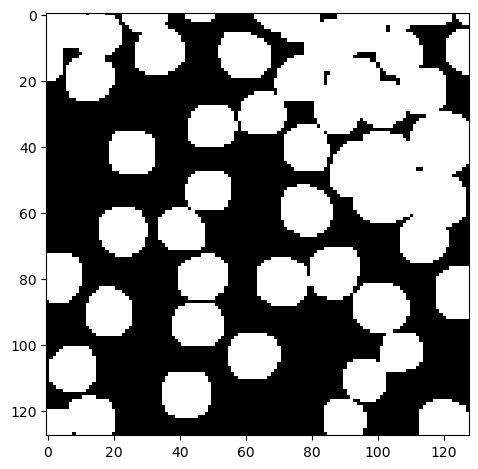

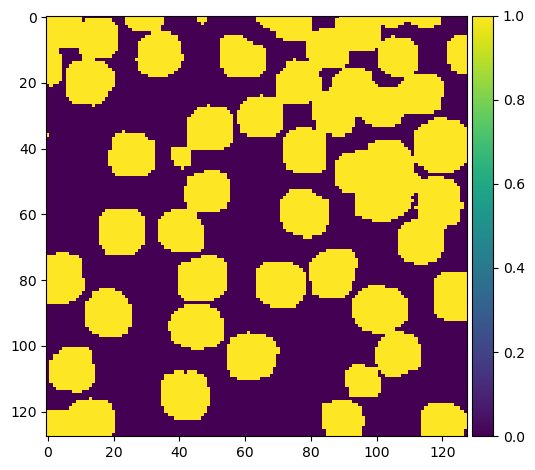

In [53]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## 인코딩 후 결과 제출

In [54]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if ( b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] +=1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff = 0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

테스트 ID를 반복하고 skimage로 식별된 각 개별 마스크에 대해 실행 길이 인코딩을 생성

In [55]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [56]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)